In [46]:
import pandas as pd
import json
import requests

In [47]:
#local file

local_file = "/content/weather.csv"

try:
    data = pd.read_csv(local_file)
    print(data.head())
    print(data.columns)
except FileNotFoundError:
    print("Error: The file was not found.")


   Data.Precipitation   Date.Full  Date.Month  Date.Week of  Date.Year  \
0                0.00  2016-01-03           1             3       2016   
1                0.00  2016-01-03           1             3       2016   
2                0.16  2016-01-03           1             3       2016   
3                0.00  2016-01-03           1             3       2016   
4                0.01  2016-01-03           1             3       2016   

  Station.City Station.Code Station.Location Station.State  \
0   Birmingham          BHM   Birmingham, AL       Alabama   
1   Huntsville          HSV   Huntsville, AL       Alabama   
2       Mobile          MOB       Mobile, AL       Alabama   
3   Montgomery          MGM   Montgomery, AL       Alabama   
4    Anchorage          ANC    Anchorage, AK        Alaska   

   Data.Temperature.Avg Temp  Data.Temperature.Max Temp  \
0                         39                         46   
1                         39                         47   
2    

In [48]:
# cleaned Data
df = pd.DataFrame(data, columns=['Station.State', 'Date.Year', 'Date.Month', 'Data.Precipitation','Data.Temperature.Avg Temp', 'Data.Wind.Speed','Data.Wind.Direction'])
df = df.loc[df['Date.Month'] == 3]

# group by 'Station.State', 'Date.Year', and 'Date.Month' + calc average for specified columns
grouped_df = df.groupby(['Station.State', 'Date.Year', 'Date.Month'])[['Data.Precipitation',
                                                                      'Data.Temperature.Avg Temp',
                                                                      'Data.Wind.Speed',
                                                                      'Data.Wind.Direction']].mean()

grouped_df = grouped_df.reset_index()
grouped_df = grouped_df.round(2)
print(grouped_df)


     Station.State  Date.Year  Date.Month  Data.Precipitation  \
0          Alabama       2016           3                1.30   
1           Alaska       2016           3                0.36   
2          Arizona       2016           3                0.02   
3         Arkansas       2016           3                1.26   
4       California       2016           3                0.84   
5         Colorado       2016           3                0.17   
6      Connecticut       2016           3                0.39   
7               DE       2016           3                0.34   
8         Delaware       2016           3                0.34   
9          Florida       2016           3                0.61   
10         Georgia       2016           3                0.72   
11          Hawaii       2016           3                0.53   
12           Idaho       2016           3                0.51   
13        Illinois       2016           3                0.63   
14         Indiana       

In [49]:
grouped_df.to_csv("2016_cleaned_data.csv", index=False)


In [50]:
# calling/creating API

import requests

def get_current_weather(api_key, location):
    try:
        url = "http://api.weatherapi.com/v1/current.json"
        params = {"key": api_key, "q": location}
        response = requests.get(url, params=params)

        response.raise_for_status()

        data = response.json()
        current = data.get("current", {})

        summary = {
            "Location": data.get("location", {}).get("region"),
            "Time": current.get("last_updated"),
            "Precipitation (mm)": current.get("precip_mm"),
            "Temperature (°F)": current.get("temp_f"),
            "Wind Speed (mph)": current.get("wind_mph"),
            "Wind Direction": current.get("wind_dir"),
        }
        return summary

    except requests.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None

# Usage
api_key = "23b0589184d4491b85923455251903"
location = "Alabama"

data = get_current_weather(api_key, location)
print(data)


{'Location': 'New York', 'Time': '2025-03-24 23:30', 'Precipitation (mm)': 0.0, 'Temperature (°F)': 37.9, 'Wind Speed (mph)': 17.9, 'Wind Direction': 'WSW'}


In [51]:
#cleaned API
country = 'USA United States of America'

# all 50 U.S. states
states = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
    "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky",
    "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi",
    "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico",
    "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont",
    "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

weather_data = []
for state in states:
    try:
        data = get_current_weather(api_key, f"{state}, {country}")
        if data:
            weather_data.append(data)
        else:
            print(f" No data returned for {state}.")
    except Exception as e:
        print(f"Error fetching data for {state}: {e}")

# convert  df and save as CSV
try:
    if weather_data:
        weather_df = pd.DataFrame(weather_data)
        weather_df.to_csv("2025_weather_data.csv", index=False)
        print("CSV file '2025_weather_data.csv' created successfully!")
    else:
        print("No weather data was collected, CSV file not created.")
except Exception as e:
    print(f"Error saving CSV file: {e}")

CSV file '2025_weather_data.csv' created successfully!


In [52]:
# 2025_weather in json (Supported Formats: You must implement support for both CSV and JSON formats
#(retrieved from either file dumps or API calls). The two data sources do not need to
#be merged but should be handled separately)

weather_df.to_json("2025_weather_data.json", orient="records", indent=4)


Cleaning the Data to be Merged

In [53]:
# in grouped df, get rid of DE, puerto rico, two ohios, and va
grouped_df2 = grouped_df.loc[~grouped_df["Station.State"].isin(["DE", "Puerto Rico", "VA", "Delaware", "Florida", "Indiana", "Oregon", "Washington", "Wyoming"])]

# weather df does not have delaware or florida or indiana or oregon or washington
# has two michigans, three ohios, two pennsylvanis, district of columbia, and puerto rico
weather_df = weather_df.sort_values(by="Location").reset_index(drop=True)
weather_df2 = weather_df.loc[~weather_df["Location"].isin(["District of Columbia", "Puerto Rico"])]
weather_df2 = weather_df2.drop_duplicates(subset="Location", keep="first").reset_index(drop=True)


In [54]:
# checking to make sure we have the same states...
# check if all states in grouped_df are present in weather_df
grouped_states = set(grouped_df2["Station.State"])
weather_states = set(weather_df2["Location"])

# find states missing from either DataFrame
missing_from_weather = grouped_states - weather_states
missing_from_grouped = weather_states - grouped_states

# error messages
print("States in grouped_df but not in weather_df:", missing_from_weather)
print("States in weather_df but not in grouped_df:", missing_from_grouped)

States in grouped_df but not in weather_df: set()
States in weather_df but not in grouped_df: set()


In [55]:
# MERGING TO COMPARE MARCH 2016 TO 2025

# rename columns to indicate source dataset
grouped_df2 = grouped_df2.add_suffix("_dataset")
weather_df2 = weather_df2.add_suffix("_api")

# merge on state/location
final_df2 = pd.merge(
    grouped_df2, weather_df2,
    left_on="Station.State_dataset", right_on="Location_api",
    how="inner"  # or "outer" if you want to keep unmatched states
)

# drop redundant state columns if necessary
final_df2.drop(columns=["Location_api"], inplace=True)

print(final_df2.head())
print(final_df2.tail())


  Station.State_dataset  Date.Year_dataset  Date.Month_dataset  \
0               Alabama               2016                   3   
1                Alaska               2016                   3   
2               Arizona               2016                   3   
3              Arkansas               2016                   3   
4            California               2016                   3   

   Data.Precipitation_dataset  Data.Temperature.Avg Temp_dataset  \
0                        1.30                              60.31   
1                        0.36                              31.48   
2                        0.02                              59.85   
3                        1.26                              55.00   
4                        0.84                              57.88   

   Data.Wind.Speed_dataset  Data.Wind.Direction_dataset          Time_api  \
0                     6.60                        19.88  2025-03-24 22:15   
1                     6.44              

In [56]:
# save merged dataset as csv file
final_df2.to_csv("final_weather_comparison.csv", index=False)
print(final_df2.head())

  Station.State_dataset  Date.Year_dataset  Date.Month_dataset  \
0               Alabama               2016                   3   
1                Alaska               2016                   3   
2               Arizona               2016                   3   
3              Arkansas               2016                   3   
4            California               2016                   3   

   Data.Precipitation_dataset  Data.Temperature.Avg Temp_dataset  \
0                        1.30                              60.31   
1                        0.36                              31.48   
2                        0.02                              59.85   
3                        1.26                              55.00   
4                        0.84                              57.88   

   Data.Wind.Speed_dataset  Data.Wind.Direction_dataset          Time_api  \
0                     6.60                        19.88  2025-03-24 22:15   
1                     6.44              

In [57]:
# save merged dataset as json file
final_df2.to_json("final_weather_comparison.json", orient="records", lines=True)

print(final_df2.head())

  Station.State_dataset  Date.Year_dataset  Date.Month_dataset  \
0               Alabama               2016                   3   
1                Alaska               2016                   3   
2               Arizona               2016                   3   
3              Arkansas               2016                   3   
4            California               2016                   3   

   Data.Precipitation_dataset  Data.Temperature.Avg Temp_dataset  \
0                        1.30                              60.31   
1                        0.36                              31.48   
2                        0.02                              59.85   
3                        1.26                              55.00   
4                        0.84                              57.88   

   Data.Wind.Speed_dataset  Data.Wind.Direction_dataset          Time_api  \
0                     6.60                        19.88  2025-03-24 22:15   
1                     6.44              

In [58]:
import pandas as pd
import sqlite3
import os

db_file = 'final_weather_comparison.db'
conn = sqlite3.connect(db_file)
final_df2.to_sql('weather_data', conn, if_exists='replace', index=False)
conn.commit()

os.system(f"sqlite3 {db_file} .dump > final_weather_comparison_dump.sql")
final_df2.to_csv('final_weather_comparison.csv', index=False)

conn = sqlite3.connect(db_file)
check_df = pd.read_sql('SELECT * FROM weather_data', conn)

print(check_df.head())
conn.close()


  Station.State_dataset  Date.Year_dataset  Date.Month_dataset  \
0               Alabama               2016                   3   
1                Alaska               2016                   3   
2               Arizona               2016                   3   
3              Arkansas               2016                   3   
4            California               2016                   3   

   Data.Precipitation_dataset  Data.Temperature.Avg Temp_dataset  \
0                        1.30                              60.31   
1                        0.36                              31.48   
2                        0.02                              59.85   
3                        1.26                              55.00   
4                        0.84                              57.88   

   Data.Wind.Speed_dataset  Data.Wind.Direction_dataset          Time_api  \
0                     6.60                        19.88  2025-03-24 22:15   
1                     6.44              

In [59]:
# SIMPLE DATA ANALYSIS TREND ON AVERAGES

# correlation Analysis
# select only precipitation, temperature, and wind speed columns
selected_cols = [
    "Data.Precipitation_dataset", "Data.Temperature.Avg Temp_dataset", "Data.Wind.Speed_dataset",
    "Precipitation (mm)_api", "Temperature (°F)_api", "Wind Speed (mph)_api"
]

correlation_matrix = final_df2[selected_cols].corr() # correlation matrix / table

print(correlation_matrix)

                                   Data.Precipitation_dataset  \
Data.Precipitation_dataset                           1.000000   
Data.Temperature.Avg Temp_dataset                    0.394337   
Data.Wind.Speed_dataset                             -0.152382   
Precipitation (mm)_api                               0.025922   
Temperature (°F)_api                                 0.113784   
Wind Speed (mph)_api                                -0.039255   

                                   Data.Temperature.Avg Temp_dataset  \
Data.Precipitation_dataset                                  0.394337   
Data.Temperature.Avg Temp_dataset                           1.000000   
Data.Wind.Speed_dataset                                    -0.149881   
Precipitation (mm)_api                                     -0.167495   
Temperature (°F)_api                                        0.805959   
Wind Speed (mph)_api                                       -0.161434   

                                   Data

Analyzing the correlation analysis, we see that:
- Precipitation levels from 2016 aren't strongly correlated with any of the other variables, but we do see a moderately average correlatino with average temperature in 2016
- Average temperatures from 2016 seem to have a strong positive correlation with average temperatures in 2025
- Wind speed from 2016 and 2025 are not strongly correlated with any other variables
- Precipitation levels from 2025 are not strongly correlated with any other variable


In [60]:
# AGGREGATION ANALYSIS

# calculate differences between March 2016 averages and latest March readings
final_df2["Temp_Diff"] = final_df2["Data.Temperature.Avg Temp_dataset"] - final_df2["Temperature (°F)_api"]
final_df2["Precip_Diff"] = final_df2["Data.Precipitation_dataset"] - final_df2["Precipitation (mm)_api"]
final_df2["Wind_Speed_Diff"] = final_df2["Data.Wind.Speed_dataset"] - final_df2["Wind Speed (mph)_api"]

summary_stats = final_df2[["Temp_Diff", "Precip_Diff", "Wind_Speed_Diff"]].describe() # summary table

print(summary_stats)


       Temp_Diff  Precip_Diff  Wind_Speed_Diff
count  44.000000    44.000000        44.000000
mean   -2.307273     0.479318         1.187500
std     7.469684     0.638109         3.612368
min   -22.720000    -2.050000        -8.070000
25%    -5.920000     0.302500        -0.672500
50%    -1.075000     0.460000         1.455000
75%     1.980000     0.680000         3.097500
max    10.750000     2.290000        12.800000


Aggregation analysis shows that:
- On average, the differece in temperature across the states is about 7 degrees warmer now than it was in 2016. There does seem to be a lot of variation in this, as the standard deviation is 8 degrees. However, based off the quantile values it does seem that in general states are having warmer temperatures this March than they did in March of 2016
- There doesn't seem to be much of a difference in precipitation from 2016 to 2025, with only about half a millimeter less precipitation now than in 2016. There doesn't seem to be much variation in this either, but we do see that the max value of 2.29 mm is probably an outlier in the data.
- Wind speed is about 3 mph higher now than it was in 2016, with a good amount of variation in the observed values.

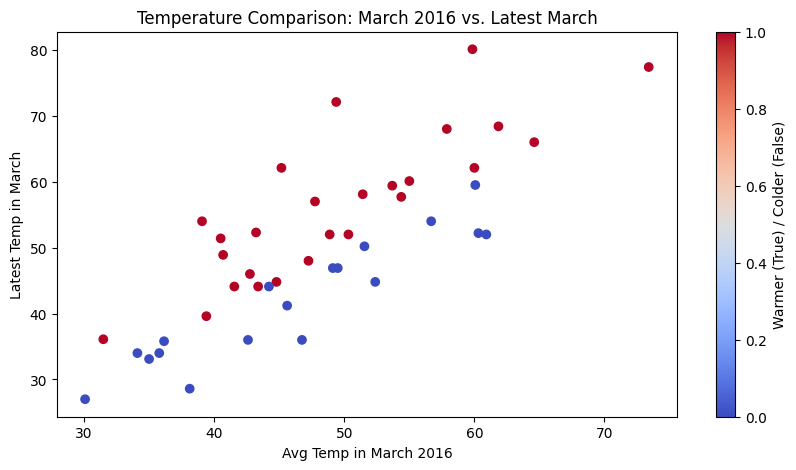

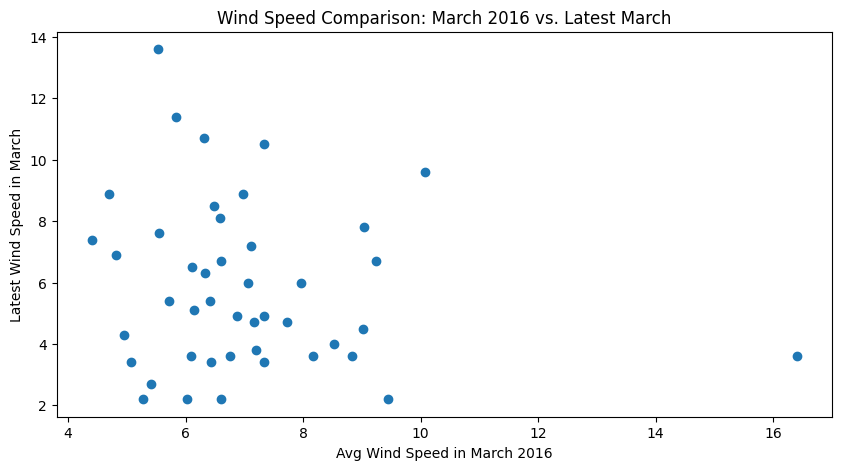

In [61]:
import matplotlib.pyplot as plt


# TRUE is warmer in 2025, FALSE if colder in 2025
final_df2["Temperature_Comparison"] = final_df2["Temperature (°F)_api"] > final_df2["Data.Temperature.Avg Temp_dataset"]
# scatterplot for temp comparison
plt.figure(figsize=(10, 5))
scatter = plt.scatter(
    final_df2["Data.Temperature.Avg Temp_dataset"],
    final_df2["Temperature (°F)_api"],
    c=final_df2["Temperature_Comparison"],  # fill by temp comparison column
    cmap='coolwarm',  # specifices red for warmer, blue for cooler
)
plt.colorbar(scatter, label="Warmer (True) / Colder (False)")
plt.xlabel("Avg Temp in March 2016")
plt.ylabel("Latest Temp in March")
plt.title("Temperature Comparison: March 2016 vs. Latest March")
plt.show()


# scatterplot for wind speed comparison
plt.figure(figsize=(10, 5))
plt.scatter(final_df2["Data.Wind.Speed_dataset"], final_df2["Wind Speed (mph)_api"])
plt.xlabel("Avg Wind Speed in March 2016")
plt.ylabel("Latest Wind Speed in March")
plt.title("Wind Speed Comparison: March 2016 vs. Latest March")
plt.show()


Data Summarization:

In [62]:
# DATA Summarization ingested data

weather_df = pd.read_csv("weather.csv")
num_columns1 = weather_df.shape[1]
num_records1 = weather_df.shape[0]

api_df = pd.read_csv("2025_weather_data.csv")
num_columns2 = api_df.shape[1]
num_records2 = api_df.shape[0]

num_columns3 = api_df.shape[1] + weather_df.shape[1]
num_records3 = api_df.shape[0] + weather_df.shape[0]

num_columns = final_df2.shape[1]
num_records = final_df2.shape[0]

print("Ingested data summary")
print("Number of records:", num_records3 )
print("Number of columns:", num_columns3)

print("After Processing summary")
print("Number of records:", num_records)
print("Number of columns:", num_columns)



Ingested data summary
Number of records: 16793
Number of columns: 20
After Processing summary
Number of records: 44
Number of columns: 16
